# LDA Model Building 

## Topic modelling only using tweets from users posted once given time period

In [1]:
import pandas as pd
import numpy as np

# LDA model building
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from tqdm import tqdm_notebook as tqdm

# Visualisations
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls

## Loading Data

In [2]:
tweet_df = pd.read_csv('tweet_climate_change_processed.csv')
len(tweet_df)

67406

#### Filter out users that posted more than once

In [3]:
# Check the duplicates
tweet_df_dup = tweet_df[tweet_df.duplicated(subset = ['ID'], keep = False)]
len(tweet_df_dup)

41134

In [4]:
# DF with tweets from users only posted once 
tweet_df_once = tweet_df.drop_duplicates(subset = ['ID'], keep = False)
len(tweet_df_once)

26272

In [5]:
tweet_df_once

,ID,Name,Tweet,Processed_text,Processed_token,Bigram
0,18257804,stateless,"we’re pretty lucky, all things considered, whe...",pretty lucky thing consider compare place clim...,"['pretty', 'lucky', 'thing', 'consider', 'comp...","['pretty', 'lucky', 'thing', 'consider', 'comp..."
5,2409478435,Norma4Congress,The evidence is right in front of us. Temperat...,evidence right temperature get hot climatechan...,"['evidence', 'right', 'temperature', 'get', 'h...","['evidence', 'right', 'temperature', 'get', 'h..."
11,987499130,LindaWilsonCBPW,#ClimateChange inordinately affects #women. An...,climatechange inordinately affect woman reason...,"['climatechange', 'inordinately', 'affect', 'w...","['inordinately', 'affect', 'woman', 'reason', ..."
14,1319875176,jhoppe47,If global warming is allowed to continue unche...,global warming allow continue unchecked antarc...,"['global', 'warming', 'allow', 'continue', 'un...","['continue_unchecke', 'antarctica_soon', 'pass..."
16,17923419,RightEyeGuy,California Nightmare \n#GreenEnergy \n#GlobalW...,california nightmare greenenergy globalwarme c...,"['california', 'nightmare', 'greenenergy', 'gl...","['globalwarme', 'climateemergency', 'climatech..."
...,...,...,...,...,...,...
67399,275654829,RachunZero,The peeps who think baby steps are the best wa...,peep think baby step good way address climatec...,"['peep', 'think', 'baby', 'step', 'good', 'way...","['peeps_think', 'baby_step', 'good', 'way', 'a..."
67401,1329260903527718913,Jillian18277886,"Once we get through #COVID, let's not forget w...",covid let forget go die climatechange,"['covid', 'let', 'forget', 'go', 'die', 'clima...","['let', 'forget', 'go', 'die', 'climatechange']"
67402,19435213,wildweatherdan,"At the end of the last Ice Age, people changed...",end ice age people change clothe literally cli...,"['end', 'ice', 'age', 'people', 'change', 'clo...","['end', 'ice', 'age', 'people', 'change', 'clo..."
67403,1401488848635502592,AnonWatchers,"Coral #reefs ,rainforest of the ocean\n🐠\n#cli...",coral reef rainforest ocean climatechange co...,"['coral', 'reef', 'rainforest', 'ocean', 'clim...","['coral_reef', 'rainforest', 'climatechange', ..."


## Data Transformation : Corpus and Dictionary 

In [ ]:
# Convert stringfied list back to list
tweet_df_once['Processed_token'] = tweet_df_once['Processed_token'].apply(eval)

In [7]:
# Create a mapping of word IDs to words
id2word = corpora.Dictionary(tweet_df_once['Processed_token'])
print(len(id2word))

26565


In [8]:
# Filter extremes
id2word.filter_extremes(no_below = 3, no_above = .99)
print(len(id2word))

11835


In [9]:
# Turns each tweet into a bag of words
corpus = [id2word.doc2bow(tweet) for tweet in tweet_df_once['Processed_token']]

### Bigram

In [16]:
# Convert stringfied list back to list
tweet_df_once['Bigram'] = tweet_df_once['Bigram'].apply(eval)

# Create a mapping of word IDs to words
id2word_bi = corpora.Dictionary(tweet_df_once['Bigram'])
print(len(id2word_bi))

/var/folders/zr/3t3krv2s4b3290bm28xqz3rm0000gn/T/ipykernel_32189/4253989350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df_once['Bigram'] = tweet_df_once['Bigram'].apply(eval)


21036


In [17]:
# Filter extremes
id2word_bi.filter_extremes(no_below = 3, no_above = .99)
print(len(id2word_bi))

9898


In [18]:
# Turns each tweet into a bag of words
corpus_bi = [id2word_bi.doc2bow(tweet) for tweet in tweet_df_once['Bigram']]

## Base Model

In [ ]:
# LDA model
base_lda = LdaMulticore(corpus = corpus, num_topics = 10, 
                       id2word = id2word, random_state = 100,
                       chunksize = 100, passes = 10)

#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
gensimvis.prepare(base_lda, corpus, id2word)


# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_lda.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_lda, texts= tweet_df_once['Processed_token'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)

In [ ]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
gensimvis.prepare(base_lda, corpus, id2word)

### Bigram

In [ ]:
# LDA model
base_lda_bi = LdaMulticore(corpus = corpus_bi, num_topics = 10, 
                       id2word = id2word_bi, random_state = 100,
                       chunksize = 100, passes = 10)

#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
gensimvis.prepare(base_lda_bi, corpus_bi, id2word_bi)


# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity_bi = base_lda_bi.log_perplexity(corpus_bi)
print('\nPerplexity: ', base_perplexity_bi) 

# Compute Coherence Score
coherence_model_bi = CoherenceModel(model=base_lda_bi, texts= tweet_df_once['Bigram'], 
                                   dictionary=id2word_bi, coherence='c_v')
coherence_lda_model_base_bi = coherence_model_bi.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base_bi)

In [20]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
gensimvis.prepare(base_lda_bi, corpus_bi, id2word_bi)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.046818 -0.026712       1        1  18.621422
7     -0.057014  0.142295       2        1  13.848830
0     -0.059145  0.147671       3        1  11.080150
3     -0.075999  0.158038       4        1   9.555830
6     -0.136458 -0.116779       5        1   8.795652
1      0.100066 -0.042486       6        1   8.323454
5     -0.064966  0.021163       7        1   8.226853
2      0.088300  0.047570       8        1   7.415508
4      0.351099 -0.043694       9        1   7.359549
8     -0.099065 -0.287066      10        1   6.772752, topic_info=         Term         Freq        Total Category  logprob  loglift
642      tree  1652.000000  1652.000000  Default  30.0000  30.0000
332     fight  1790.000000  1790.000000  Default  29.0000  29.0000
172    normal  1078.000000  1078.000000  Default  28.0000  28.0000
131    change  3452.000000  3452.000000  Default  27.0000  27.0000
773  mangrove   932.000000   932.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
259     issue   130.340688   527.228166  Topic10  -5.1446   1.2948
177    global   144.808321  1124.022124  Topic10  -5.0394   0.6430
132   climate   181.156310  5856.666080  Topic10  -4.8154  -0.7837
715    health   127.722752   680.759895  Topic10  -5.1649   1.0189
912    tackle   128.139028   748.558188  Topic10  -5.1617   0.9272

[601 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1287      5  0.994469     access
828       1  0.303857        act
828       4  0.090808        act
828       7  0.600729        act
17        1  0.683015     action
...     ...       ...        ...
47        9  0.009392       year
47       10  0.031109       year
913       7  0.005904  yesterday
913       9  0.991817  yesterday
1631      3  0.996586    youtube

[967 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 1, 4, 7, 2, 6, 3, 5, 9])

## Hyperparameter Tuning

In [45]:
def coherence_score(corpus, id2word, k, a, b):
    
    lda_model = LdaMulticore(corpus = corpus,  
                             id2word = id2word,
                             num_topics = k,
                             alpha = a,
                             eta = b,
                             random_state = 100,
                             chunksize = 100, 
                             passes = 10)
    coherence_model_lda = CoherenceModel(model = lda_model,
                                        texts = tweet_df_once['Processed_token'],
                                        dictionary = id2word,
                                        coherence = 'c_v')
    
    return coherence_model_lda.get_coherence()

In [47]:
# Topic number k range
min_topics = 4
max_topics = 12
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha 
alpha = [0.05, 0.1, 0.5, 1.5, 10]
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta
beta = [0.05, 0.1, 0.5, 1.5, 10]
beta.append('symmetric')

model_results = {'Topics' : [],
                'Alpha' : [],
                'Beta' : [],
                'Coherence' : []
                }


if 1 == 1:
    pbar = tqdm(total = 336)
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterate through beta values
            for b in beta:
                c = coherence_score(corpus = corpus, 
                                    id2word = id2word,
                                    k = k, a = a, b = b)
                
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(c)
                
                pbar.update(1)
                
model_result = pd.DataFrame(model_results)
pbar.close()

/var/folders/zr/3t3krv2s4b3290bm28xqz3rm0000gn/T/ipykernel_32189/1902571521.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(total = 336)


  0%|          | 0/336 [00:00<?, ?it/s]

In [51]:
model_result.sort_values(by = ['Coherence'], ascending = False)

,Topics,Alpha,Beta,Coherence
214,9,0.05,10,0.580216
244,9,symmetric,10,0.579170
34,4,symmetric,10,0.576851
220,9,0.1,10,0.573718
262,10,0.1,10,0.573148
...,...,...,...,...
153,7,10,1.5,0.196447
192,8,10,0.05,0.194606
111,6,10,1.5,0.194094
281,10,10,symmetric,0.183116


## Best Model - Visualisation

### pyLDAvis

In [53]:
model_result.to_csv('LDA_tuning_results_once.csv', index = False)

In [12]:
# LDA model
best_lda = LdaMulticore(corpus = corpus, 
                           num_topics = 9, 
                           id2word = id2word, 
                           random_state = 100,
                           chunksize = 100,
                           passes = 10, 
                          alpha =0.05,
                          eta = 10)

#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_lda, corpus, id2word)

In [13]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.142100 -0.022174       1        1  66.406770
5      0.023707  0.077539       2        1  22.645202
1     -0.021370 -0.009841       3        1   2.711460
7     -0.026448 -0.010151       4        1   2.102926
4     -0.023825 -0.007752       5        1   1.520355
2     -0.023779 -0.005817       6        1   1.459819
8     -0.022821 -0.007996       7        1   1.213294
6     -0.023609 -0.006863       8        1   0.987587
0     -0.023956 -0.006945       9        1   0.952587, topic_info=             Term        Freq       Total Category  logprob  loglift
220        normal  597.000000  597.000000  Default  30.0000  30.0000
29    temperature  600.000000  600.000000  Default  29.0000  29.0000
237      heatwave  453.000000  453.000000  Default  28.0000  28.0000
1401       record  488.000000  488.000000  Default  27.0000  27.0000
543       weather  437.000000  437.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
2058         meat    0.977376   75.503340   Topic9  -8.3141   0.3067
685          love    1.007424  127.295503   Topic9  -8.2838  -0.1854
317       plastic    1.059472  204.119640   Topic9  -8.2334  -0.6072
1310         book    0.967975  112.268411   Topic9  -8.3238  -0.0997
1998        italy    1.004469  165.562168   Topic9  -8.2868  -0.4511

[431 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
11550      1  0.505141  aasimsajjada
11550      2  0.252571  aasimsajjada
11550      3  0.050514  aasimsajjada
11550      4  0.050514  aasimsajjada
11550      5  0.050514  aasimsajjada
...      ...       ...           ...
7327       2  0.305429      zoanthid
7327       3  0.061086      zoanthid
7327       4  0.061086      zoanthid
7327       5  0.061086      zoanthid
7327       7  0.061086      zoanthid

[2141 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 2, 8, 5, 3, 9, 7, 1])

In [17]:
# Saving the vis
pyLDAvis.save_html(vis, 'best_model_vis_once.html')

In [15]:
# Saving the model 
import joblib
model = best_lda
filename = 'best_lda_once_model.sav'
joblib.dump(model, filename)

# Load the model 
loaded_model = joblib.load(filename)

['best_lda_once_model.sav']

### Word Clouds

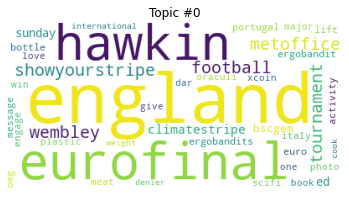

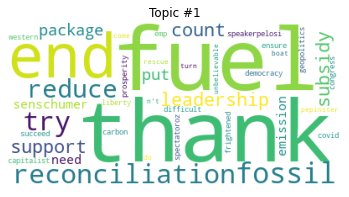

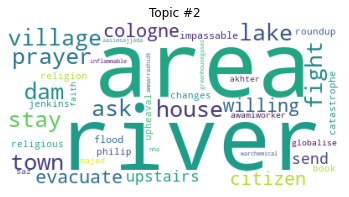

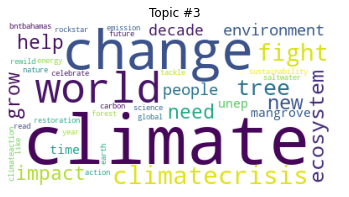

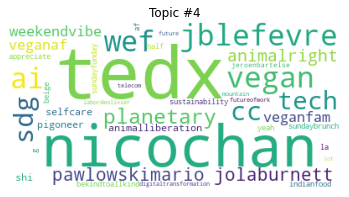

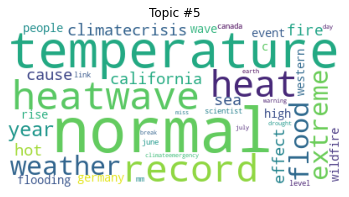

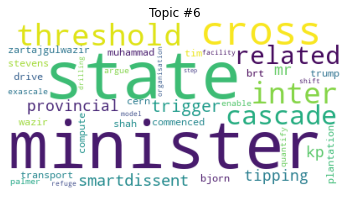

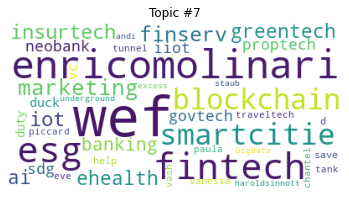

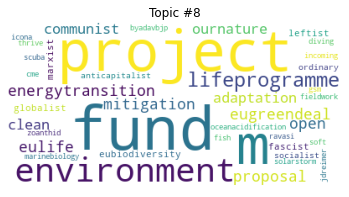

In [99]:
# word clouds
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image

for i in range(0, best_lda.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color = 'white').fit_words(dict(best_lda.show_topic(i, topn = 40))))
    plt.axis('off')
    plt.title('Topic #' + str(i))
    plt.show()

### Customised Word Cloud

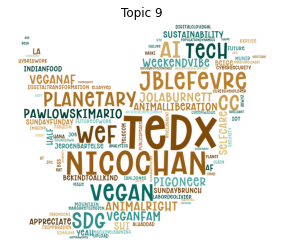

In [183]:
cloud_dict = dict(best_lda.show_topic(4, topn = 100))
# delete useless words
list_remove = ['climate', 'change', 'g', 'co', 'c', 'f', 's', 'mm', "n't", 'do',
              'k', 't', 'rn', 'q', 'd', 'ww', 'm', 'ed', 'v']
for w in list_remove:
    cloud_dict.pop(w, None)  

# font and image path
font_path = 'chiken_dinner_2/Chicken Dinner Font by  7NTypes.otf'
mask_path = 'twitter_mask.png'
mask = np.array(Image.open(mask_path))

# create custom colormap
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
# Remove the middle 40% of the RdBu_r colormap
interval = np.hstack([np.linspace(0, 0.3), np.linspace(0.7, 1)])
colors = plt.cm.BrBG(interval)
cmap = LinearSegmentedColormap.from_list('name', colors)


# word cloud generate
w_cloud = WordCloud(background_color = 'white', width=640,height= 640, stopwords = STOPWORDS,
                   font_path = font_path, mask = mask,
                    colormap = cmap)
w_cloud.fit_words(cloud_dict)

# image generate 
plt.figure()
plt.imshow(w_cloud)
plt.axis('off')
plt.title('Topic 9')
plt.show()
w_cloud.to_file('topic9.png')

In [179]:
cloud_dict = dict(best_lda.show_topic(4, topn = 100))
cloud_dict.pop('climate', None)  
cloud_dict.pop('change', None)     
cloud_dict

{'tedx': 0.0009593645,
 'nicochan': 0.00058413594,
 'jblefevre': 0.00049564237,
 'vegan': 0.00048358002,
 'wef': 0.00046530095,
 'ai': 0.0004537492,
 'sdg': 0.0003808947,
 'cc': 0.00038013398,
 'tech': 0.00036376505,
 'planetary': 0.00035954293,
 'pawlowskimario': 0.00034464634,
 'jolaburnett': 0.00034309755,
 'animalright': 0.0003371827,
 'veganaf': 0.00032569317,
 'pigoneer': 0.00032569317,
 'veganfam': 0.00032569317,
 'weekendvibe': 0.00032569317,
 'selfcare': 0.00032569317,
 'animalliberation': 0.00032569317,
 'shi': 0.00032447733,
 'sustainability': 0.0003233368,
 'la': 0.00030266662,
 'half': 0.00029989358,
 'appreciate': 0.0002987268,
 'g': 0.0002974354,
 'yeah': 0.00029063344,
 'af': 0.00028882016,
 'bekindtoallkind': 0.00028882016,
 'beige': 0.00028882016,
 'sundaybrunch': 0.00028882016,
 'sundayfunday': 0.00028882016,
 'indianfood': 0.00028882016,
 'jeroenbartelse': 0.0002883486,
 'digitaltransformation': 0.00028538526,
 'iot': 0.00028192988,
 'telecom': 0.0002806372,
 'labor

### Bigram

In [21]:
def coherence_score(corpus, id2word, k, a, b):
    
    lda_model = LdaMulticore(corpus = corpus,  
                             id2word = id2word,
                             num_topics = k,
                             alpha = a,
                             eta = b,
                             random_state = 100,
                             chunksize = 100, 
                             passes = 10)
    coherence_model_lda = CoherenceModel(model = lda_model,
                                        texts = tweet_df_once['Bigram'],
                                        dictionary = id2word,
                                        coherence = 'c_v')
    
    return coherence_model_lda.get_coherence()

In [26]:
# Topic number k range
min_topics = 4
max_topics = 12
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha 
alpha = [0.05, 0.1, 0.5, 1.5, 10]
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta
beta = [0.05, 0.1, 0.5, 1.5, 10]
beta.append('symmetric')

model_results = {'Topics' : [],
                'Alpha' : [],
                'Beta' : [],
                'Coherence' : []
                }


if 1 == 1:
    pbar = tqdm(total = 336)
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterate through beta values
            for b in beta:
                c = coherence_score(corpus = corpus_bi, 
                                    id2word = id2word_bi,
                                    k = k, a = a, b = b)
                
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(c)
                
                pbar.update(1)
                
model_result = pd.DataFrame(model_results)
pbar.close()

/var/folders/zr/3t3krv2s4b3290bm28xqz3rm0000gn/T/ipykernel_32189/3322961555.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(total = 336)


  0%|          | 0/336 [00:00<?, ?it/s]

In [28]:
model_result = pd.DataFrame(model_results)
model_result.to_csv('LDA_tuning_results_once.csv', index = False)

In [29]:
model_result.sort_values(by = ['Coherence'], ascending = False)

,Topics,Alpha,Beta,Coherence
105,6,1.5,1.5,0.367142
60,5,1.5,0.05,0.362413
148,7,1.5,10,0.362386
232,9,1.5,10,0.357187
147,7,1.5,1.5,0.355390
...,...,...,...,...
323,11,10,symmetric,0.213984
194,8,10,0.5,0.212879
152,7,10,0.5,0.211644
27,4,10,1.5,0.210491


In [34]:
# LDA model
best_lda_bi = LdaMulticore(corpus = corpus_bi, 
                           num_topics = 6, 
                           id2word = id2word_bi, 
                           random_state = 100,
                           chunksize = 100,
                           passes = 10, 
                          alpha = 1.5,
                          eta = 1.5)

#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_lda_bi, corpus_bi, id2word_bi)

In [35]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.083231  0.061779       1        1  18.379474
0     -0.205802  0.085563       2        1  18.221740
3      0.068431  0.099249       3        1  17.956262
1      0.111459  0.010699       4        1  17.811986
2     -0.053092 -0.069483       5        1  14.592432
4     -0.004227 -0.187806       6        1  13.038107, topic_info=              Term          Freq         Total Category  logprob  loglift
132        climate   4699.000000   4699.000000  Default  30.0000  30.0000
131         change   2762.000000   2762.000000  Default  29.0000  29.0000
216          world   1792.000000   1792.000000  Default  28.0000  28.0000
19   climatecrisis   2472.000000   2472.000000  Default  27.0000  27.0000
2    climatechange  19659.000000  19659.000000  Default  26.0000  26.0000
..             ...           ...           ...      ...      ...      ...
735          power    129.503241    245.476243   Topic6  -5.8060   1.3978
635          plant    133.223255    268.462528   Topic6  -5.7777   1.3366
9             grow    106.251097    209.856759   Topic6  -6.0039   1.3567
25             let     96.434317    354.603678   Topic6  -6.1009   0.7352
26          planet     94.378563    735.935773   Topic6  -6.1224  -0.0165

[320 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1141      1  0.010379     absorb
1141      2  0.010379     absorb
1141      3  0.010379     absorb
1141      4  0.923756     absorb
1141      5  0.020759     absorb
...     ...       ...        ...
913       2  0.025438  yesterday
913       3  0.012719  yesterday
913       4  0.012719  yesterday
913       5  0.012719  yesterday
913       6  0.012719  yesterday

[1656 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 4, 2, 3, 5])